# Survival Analysis : branch for time of an events.
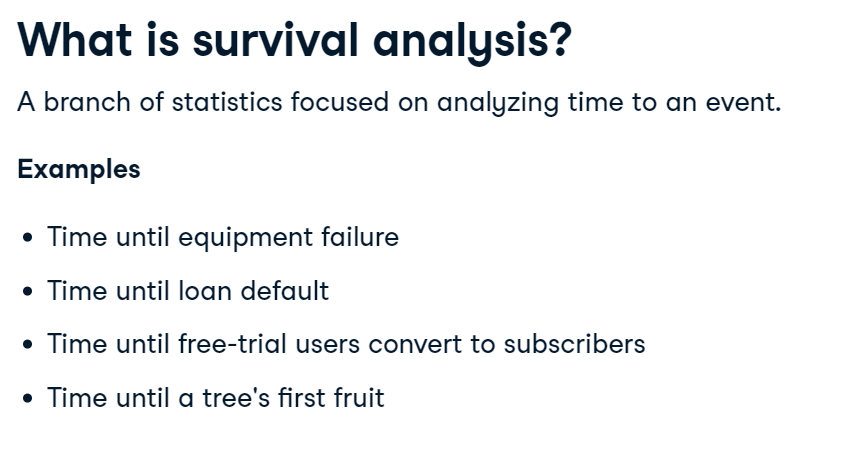

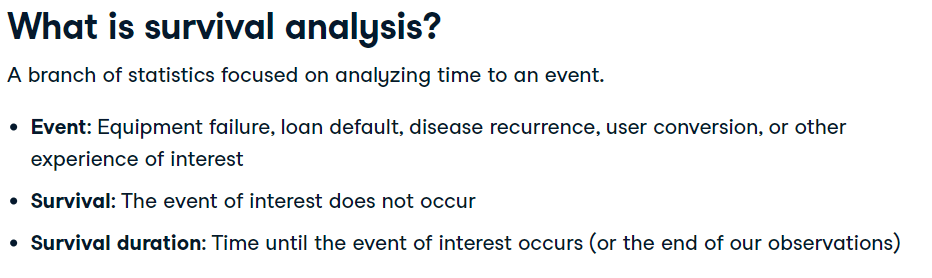
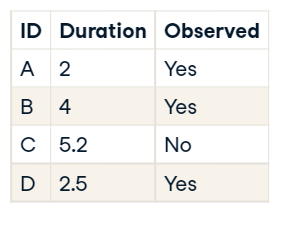

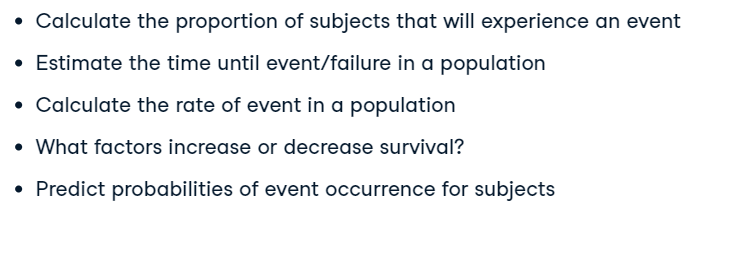

# Why Survival Analysis?
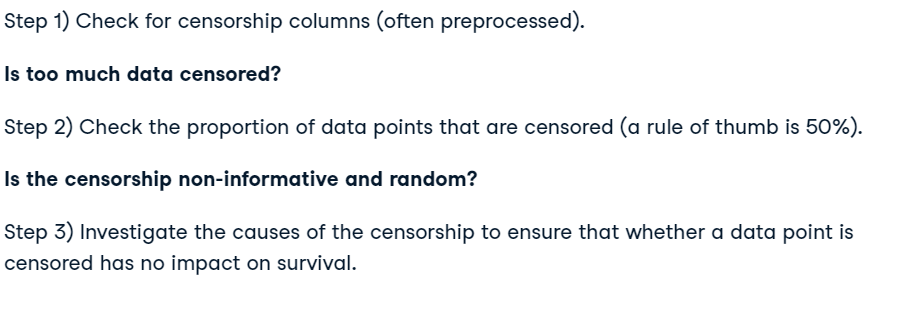

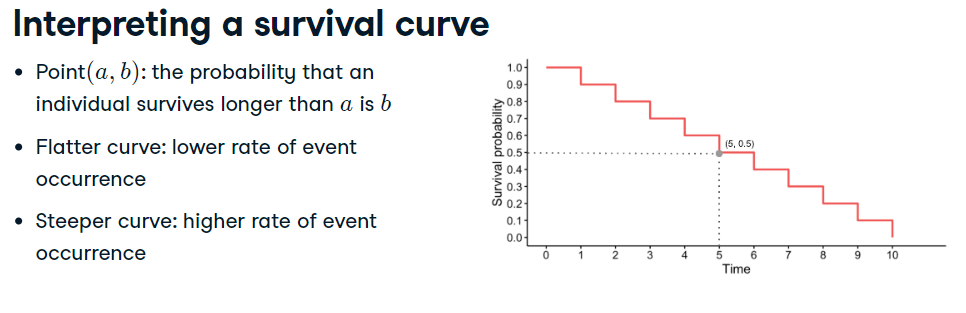

In [2]:
import numpy as np
import pandas as pd
import dc_stat_think as dcst
from dc_stat_think.original import *
import matplotlib.pyplot as plt


 i - observation number
 
 h - time in hours since experiment start
 
 f - number of failed lamps at particular time h
 
 K - number of surviving lamps  at particular time h


In [3]:
# Load the data file
#hours till start , survived
df = pd.read_csv('lamps.csv', index_col=0)
df.head()

,h,f,K
i,,,
0,0,0,50
1,840,2,48
2,852,1,47
3,936,1,46
4,960,1,45


# PMF , CDF , SURVIVAL , HAZARD

In [14]:
pmf=pd.Series(df['f'].values , index=df['h'] )
pmf.index.name ='Hour'

In [15]:
pmf.head()

Hour
0      0
840    2
852    1
936    1
960    1
dtype: int64

In [16]:
pmf /= pmf.sum()
pmf.head()

Hour
0      0.00
840    0.04
852    0.02
936    0.02
960    0.02
dtype: float64

In [17]:
pmf[840] #how many % died at time 840

0.04

Text(0, 0.5, 'PMF')

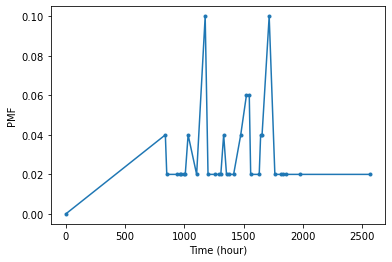

In [18]:
plt.plot(pmf.index , pmf , marker='.')
plt.xlabel('Time (hour)')
plt.ylabel('PMF')

#### Pmfs tend to be noisy but looking at the data it's between 1000 and 2000

In [19]:
cdf=pmf.cumsum()

Text(0, 0.5, 'Percentage Died')

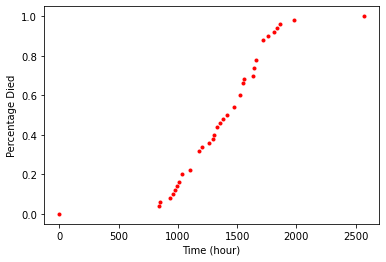

In [20]:
plt.plot(cdf , marker='.' , linestyle='none' , color='red')
plt.xlabel("Time (hour)")
plt.ylabel("Percentage Died")

# Survival = 1-cdf

In [21]:
survival=1-cdf
survival.head()

Hour
0      1.00
840    0.96
852    0.94
936    0.92
960    0.90
dtype: float64

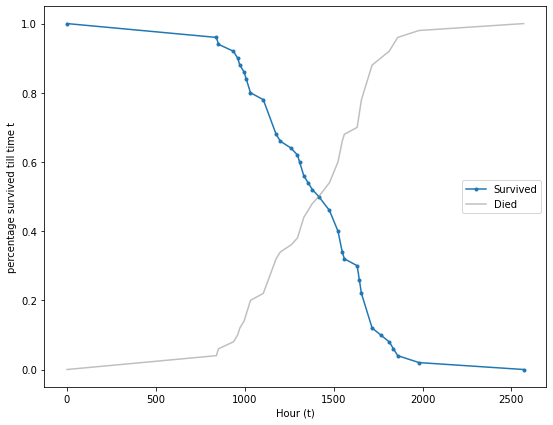

In [22]:
plt.figure(figsize=(9,7))
plt.plot(survival , marker='.')
plt.xlabel("Hour (t)")
plt.ylabel("percentage survived till time t")
plt.plot(cdf , alpha=0.5 , color='gray')
plt.legend(["Survived" , "Died"])

# Hazard Function : survival till time t, and died at time t.
## Pmf / (pmf + survival)

In [23]:
hazard_function= pmf / (pmf + survival)

In [24]:
hazard_function.head()

Hour
0      0.000000
840    0.040000
852    0.020833
936    0.021277
960    0.021739
dtype: float64

what is it saying in 840 : 0.04 ?
at all the things that survived till time 840 , 4% of them died at that point

Text(0.5, 1.0, '% of the bulbs that died from those who survived till this point')

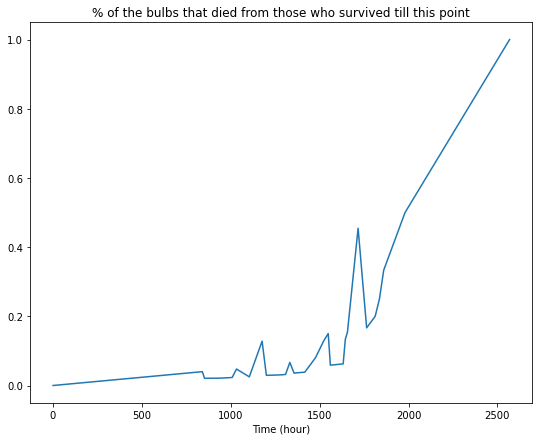

In [25]:
plt.figure(figsize=(9,7))
plt.plot(hazard_function)
plt.xlabel("Time (hour)")
plt.title("% of the bulbs that died from those who survived till this point")

# Plot the cumulative hazard_function to denoise
you can know where the danger by looking at high scope

Text(0.5, 1.0, '% of the bulbs that died from those who survived till this point')

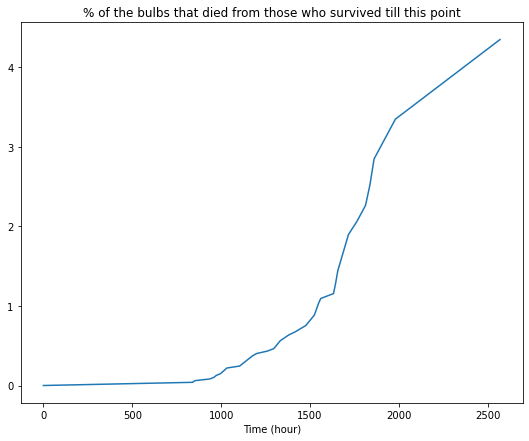

In [26]:
plt.figure(figsize=(9,7))
plt.plot(hazard_function.cumsum())
plt.xlabel("Time (hour)")
plt.title("% of the bulbs that died from those who survived till this point")

In [27]:
from scipy.stats import gaussian_kde

kde = gaussian_kde(pmf.index, weights=pmf)
#size = df['f'].sum()
size=100

In [28]:
def make_hazard(sample):
    pmf = pd.Series(sample).value_counts(normalize=True).sort_index()    
    cdf = pmf.cumsum()
    surv = 1 - cdf
    haz = pmf / (pmf + surv)
    return pmf, cdf, surv, haz

<AxesSubplot:xlabel='Hour'>

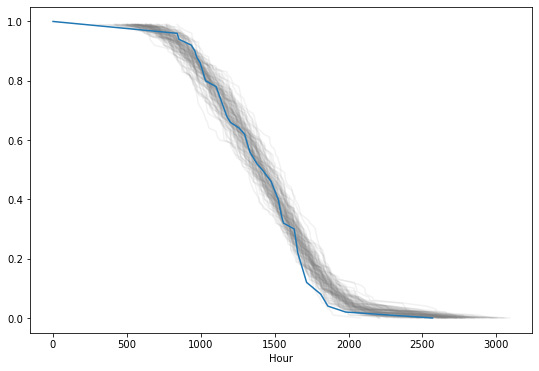

In [18]:
plt.figure(figsize=(9,6))
for i in range(100):
    sample = kde.resample(size).flatten()
    _, _, sf, _ = make_hazard(sample)
    sf.plot(color='gray', alpha=0.1)
    
survival.plot()

<AxesSubplot:xlabel='Hour'>

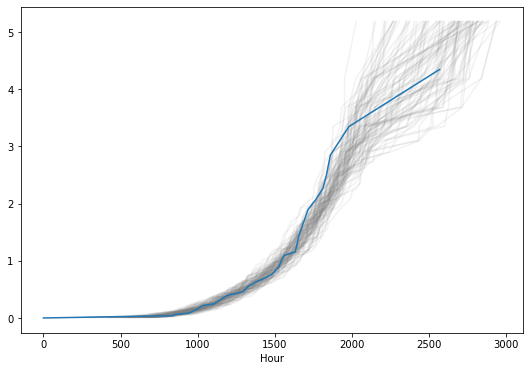

In [19]:
plt.figure(figsize=(9,6))
for i in range(100):
    sample = kde.resample(size).flatten()
    _, _, _, hf = make_hazard(sample)
    hf.cumsum().plot(color='gray', alpha=0.1)

hazard_function.cumsum().plot()

# Kaplan Meier

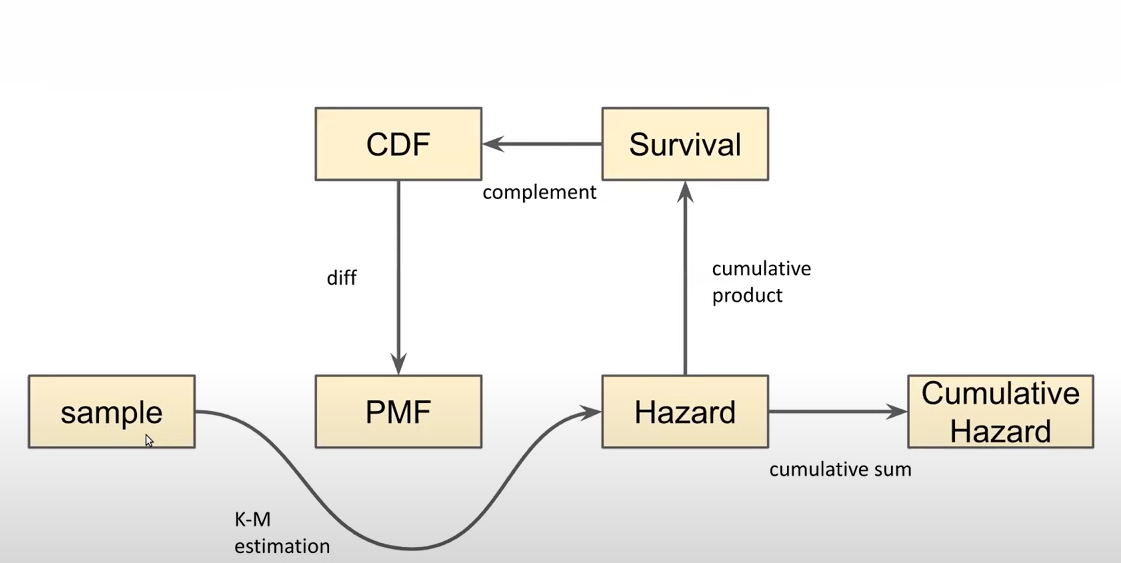

In [21]:
obs = pd.DataFrame()

obs['start'] = 0,1,2,2,4,6,7
obs['end'] = 5,2,6,9,9,8,9
obs['status'] = 1,1,1,0,0,1,0

obs

,start,end,status
0,0,5,1
1,1,2,1
2,2,6,1
3,2,9,0
4,4,9,0
5,6,8,1
6,7,9,0


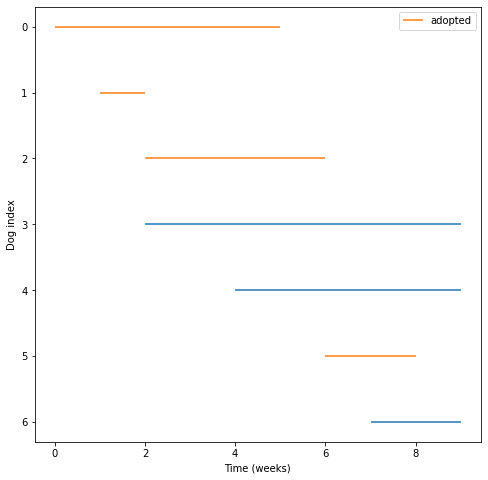

In [45]:
#plot lifelines
plt.figure(figsize=(8,8))
#y , start , end

for i in range(7):
    if obs['status'][i]==0:
        plt.hlines(obs.index[i] , obs['start'][i] , obs['end'][i] , color='C0')
    else :
        plt.hlines(obs.index[i] , obs['start'][i] , obs['end'][i] , color='C1')
plt.legend(["adopted"])
plt.xlabel('Time (weeks)')
_=plt.ylabel('Dog index')
plt.gca().invert_yaxis()

In [57]:
#first complete vs incomplete
durations=obs['end'] - obs['start']
shifted = obs.copy()
shifted['start'] = 0
shifted['end'] = durations
shifted

,start,end,status
0,0,5,1
1,0,1,1
2,0,4,1
3,0,7,0
4,0,5,0
5,0,2,1
6,0,2,0


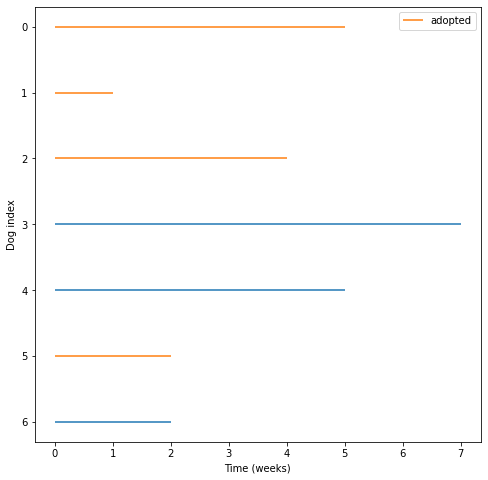

In [58]:
#plot lifelines
plt.figure(figsize=(8,8))
#y , start , end

for i in range(7):
    if shifted['status'][i]==0:
        plt.hlines(shifted.index[i] , shifted['start'][i] , shifted['end'][i] , color='C0')
    else :
        plt.hlines(shifted.index[i] , shifted['start'][i] , shifted['end'][i] , color='C1')
plt.legend(["adopted"])
plt.xlabel('Time (weeks)')
_=plt.ylabel('Dog index')
plt.gca().invert_yaxis()

In [59]:
complete = durations[obs['status'] == 1]
ongoing=durations[obs['status'] == 0]

In [66]:
def make_pmf(sample):
    return sample.value_counts().sort_index()

In [71]:
pmf_complete=make_pmf(complete)
pmf_ongoing=make_pmf(ongoing)

In [75]:
d= dict(pmf_complete=pmf_complete , pmf_ongoing=pmf_ongoing)
index=pmf_complete.index.union(pmf_ongoing.index)
df=pd.DataFrame(d,index).fillna(0)

In [76]:
df

,pmf_complete,pmf_ongoing
1,1.0,0.0
2,1.0,1.0
4,1.0,0.0
5,1.0,1.0
7,0.0,1.0


In [79]:
def make_surv(pmf):
    cdf=pmf.cumsum()
    return pmf.sum() - cdf

In [80]:
df['s_complete'] = make_surv(df['pmf_complete'])

In [83]:
df['s_ongoing'] = make_surv(df['pmf_ongoing'])

In [85]:
df['at_risk'] = df.sum(axis=1)

In [86]:
df

,pmf_complete,pmf_ongoing,s_complete,s_ongoing,at_risk
1,1.0,0.0,3.0,3.0,7.0
2,1.0,1.0,2.0,2.0,6.0
4,1.0,0.0,1.0,2.0,4.0
5,1.0,1.0,0.0,1.0,3.0
7,0.0,1.0,0.0,0.0,1.0


In [87]:
df['hazard'] = df['pmf_complete'] / df['at_risk']

In [88]:
df

,pmf_complete,pmf_ongoing,s_complete,s_ongoing,at_risk,hazard
1,1.0,0.0,3.0,3.0,7.0,0.142857
2,1.0,1.0,2.0,2.0,6.0,0.166667
4,1.0,0.0,1.0,2.0,4.0,0.250000
5,1.0,1.0,0.0,1.0,3.0,0.333333
7,0.0,1.0,0.0,0.0,1.0,0.000000


In [4]:
 df.head()

,h,f,K
i,,,
0,0,0,50
1,840,2,48
2,852,1,47
3,936,1,46
4,960,1,45


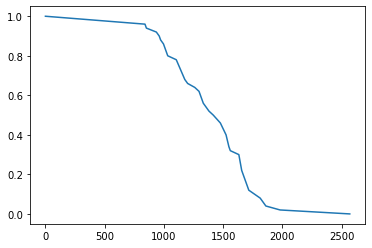

In [7]:
plt.plot(df['h'] , df['K'] / df['K'].max())

In [35]:
import lifelines 

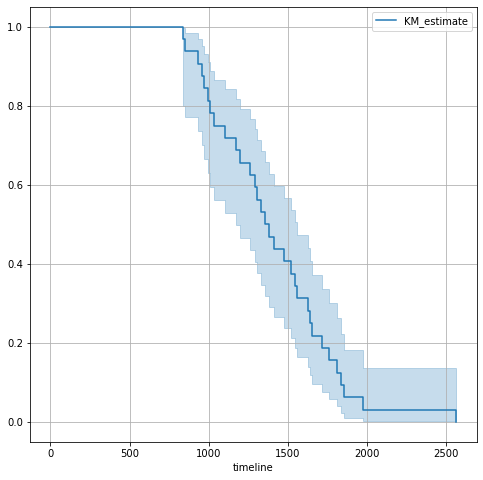

In [44]:
km_fitter=lifelines.KaplanMeierFitter().fit(df['h'] , df['f']) #duration + observed values at that duration
plt.figure(figsize=(8,8))
km_fitter.plot_survival_function()
plt.grid()

In [59]:
#pmf : amout of killed at time t from all the killed
pmf=df['f']
pmf /=pmf.sum()
pmf.head()

i
0    0.00
1    0.04
2    0.02
3    0.02
4    0.02
Name: f, dtype: float64

In [60]:
_,cdf=ecdf(pmf)

In [66]:
survival = 1-cdf
hazard= pmf / (pmf + survival)
hazard=hazard.cumsum()

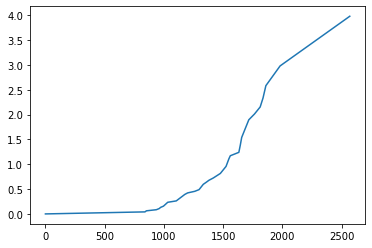

In [67]:
plt.plot(df['h'] , hazard)

<AxesSubplot:xlabel='timeline'>

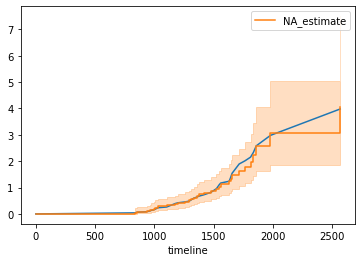

In [73]:
from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter()

naf.fit(df['h'],
        df['f'])
plt.plot(df['h'] , hazard)
naf.plot_cumulative_hazard()

# Comparing 2 Survival Curves : null hypothesis tests
# YOU CAN USE K-S OR CHI SQUARE OR LOG -RANK
# LOG-RANK IS BUILT IN LIFELINES , THE REST IS IN HYPOTHESISTESTING nb

# Kaplan meier was non parametric
# Our first Parametric Mode : Weibull , lamda , k
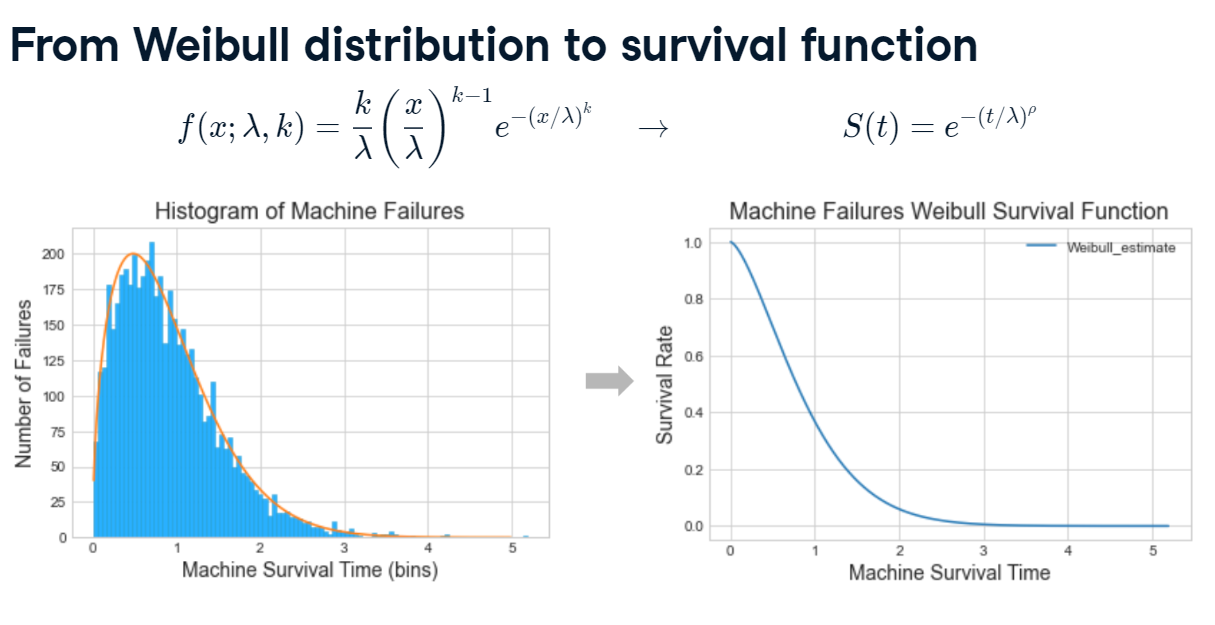
when k = 1 it's the exp distribution
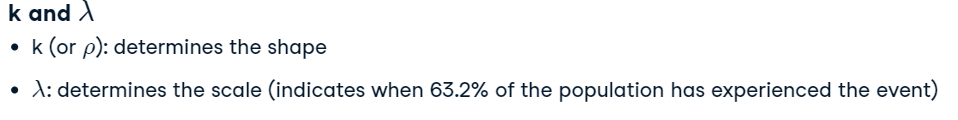

In [15]:
from lifelines import WeibullFitter , KaplanMeierFitter

                coef   se(coef)  coef lower 95%  coef upper 95%  cmp to          z             p    -log2(p)
lambda_  1550.739831  76.144574     1401.499208     1699.980454     1.0  20.352597  4.403183e-92  303.478838
rho_        3.817512   0.485156        2.866623        4.768401     1.0   5.807433  6.343805e-09   27.232005


<AxesSubplot:>

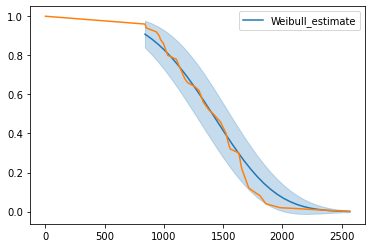

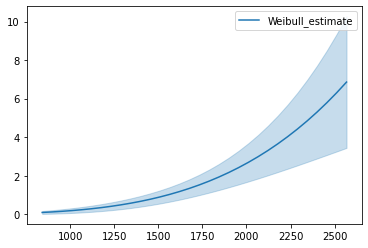

In [28]:
my_fitter = WeibullFitter().fit(durations=df['h'].iloc[1 :] , event_observed=df['f'].iloc[1:])
my_fitter.plot_survival_function()
print(my_fitter.summary)
plt.plot(df['h'] , df['K'] / df['K'].max())
plt.figure()
my_fitter.plot()

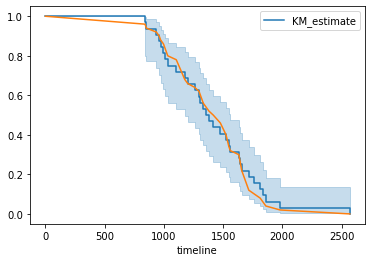

In [31]:
my_fitter = KaplanMeierFitter().fit(durations=df['h'].iloc[1 :] , event_observed=df['f'].iloc[1:])
my_fitter.plot_survival_function()
plt.plot(df['h'] , df['K'] / df['K'].max())

# Survival Regression